In [1]:
# !pip install matplotlib-venn

In [37]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
import plotly.express as px
import japanize_matplotlib
import numpy as np
from datetime import datetime
import scipy.sparse as sp
from functools import partial

import random
# ランダムに生成す値のシードを固定して再現性を担保する
def seed_everything(seed:int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
sns.set_context("talk")
seed_everything(510)

from typing import List
from contextlib import contextmanager
from time import time

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgbm



In [3]:
# コードの実行時間を計測する便利関数
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [4]:
# --- 1. 全データの読み込み ---
INPUT_DIR = "../"

In [5]:
# 出力のディレクトリを作成
OUTPUT_DIR = "../outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [41]:
# --- 1. 全データの読み込み ---

df_train = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
df_test = pd.read_csv(os.path.join(INPUT_DIR, "test.csv"))
df_position = pd.read_csv(os.path.join(INPUT_DIR, "position_history.csv"))
df_overtime = pd.read_csv(os.path.join(INPUT_DIR, "overtime_work_by_month.csv"))
df_hr = pd.read_csv(os.path.join(INPUT_DIR, "hr.csv"))
df_dx = pd.read_csv(os.path.join(INPUT_DIR, "dx.csv"))
df_udemy = pd.read_csv(os.path.join(INPUT_DIR, "udemy_activity.csv"))
df_career = pd.read_csv(os.path.join(INPUT_DIR, "career.csv"), encoding='utf-8-sig')


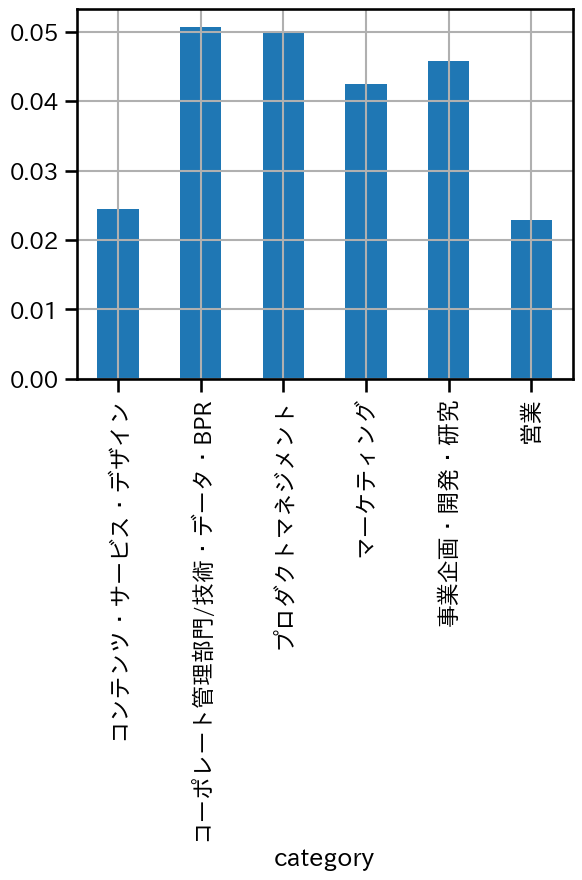

In [7]:
# 初手の可視化は目的変数から。目的変数がどのくらいの頻度で出てきているのか
ax = df_train.groupby("category")["target"].mean().plot(kind="bar")
ax.grid()

目的変数の可視化から、ポジティブデータが全体の2～5％ととても少ないことが分かる


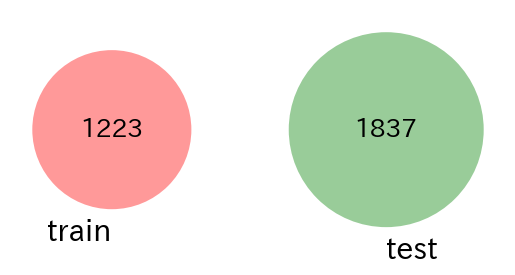

In [8]:
# データの重なりの可視化
# trainデータとtestデータで社員に重なりが無いかを確認
venn2(subsets=(set(df_train["社員番号"].unique()), set(df_test["社員番号"].unique())), set_labels=("train", "test"))

trainデータとtestデータで社員に重なりが無いことが分かる。

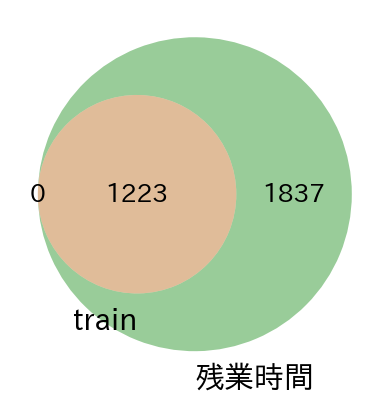

In [9]:
# 残業時間ごとに応募カテゴリの応募率はどうなっているのか？ベン図を書いてみる
venn2(subsets=(set(df_train["社員番号"].unique()), set(df_overtime["社員番号"].unique())), set_labels=("train", "残業時間"))


残業時間が無いようなtrainデータは無い。
残業時間の欠損が無いので、より機械学習に使いやすい。

他のベン図も作ってみる

C:\Users\堀江雅彦\AppData\Local\Temp\ipykernel_27408\1820460831.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  z= df_train.groupby([hours, "category"])["target"].mean().unstack()


<Axes: xlabel='category', ylabel='社員番号'>

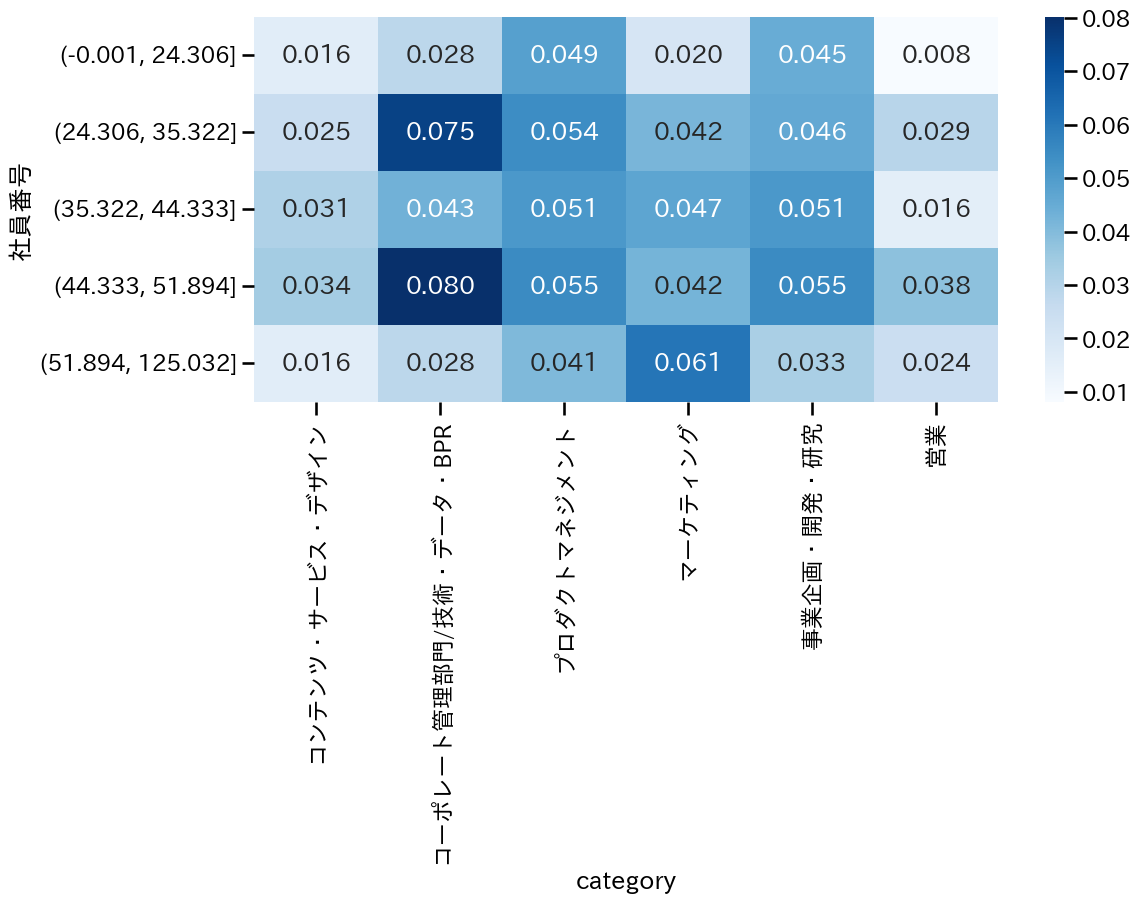

In [10]:
# 社員ごとに平均残業時間を求める
mean_hours_by_workers = df_overtime.groupby("社員番号")["hours"].mean()

# q-cutはquantile cutの略で、連続地を書く幅が同じくらいのデータになるように区切ってくれる
mean_hours_by_workers = pd.qcut(mean_hours_by_workers, q=5)
hours =df_train["社員番号"].map(mean_hours_by_workers)

# 縦軸が1人当たりの残業時間となる
z= df_train.groupby([hours, "category"])["target"].mean().unstack()

fig, ax = plt.subplots(figsize=(12,5))
sns.heatmap(z, cmap="Blues", annot=True, fmt=".3f", ax=ax)

社員ごとの残業時間の可視化により、
・マーケティングは残業時間が増えると公募が増える
・PdMや事業企画は残業時間に関わらず。
・コンテンツや営業は真ん中にピークがある
・コーポレートは真ん中にピークがある。
中程度の残業時間を持っている人が公募に手を上げやすい

特徴量エンジニアリング：df_position


In [11]:
# 社員番号の年度の最大から最小を引くと在籍年数になる
df_position_working_years = df_position.groupby("社員番号")["year"].max() - df_position.groupby("社員番号")["year"].min()
print(df_position_working_years)

# 在籍年数をあらたな特徴量とする関数を作成
def merge_by_worker_id(left, right):
    return pd.merge(left["社員番号"], right, on="社員番号", how="left").drop(columns=["社員番号"])


社員番号
-1sqs0GXzpPJuAVKHUUFgg==    2
-2Sq3E0WkZj8pL7jxdL3Cg==    1
-4jh26kLzkU8JFQwdeQU9w==    2
-4taxxVbT1nU-J5fHWmDfQ==    2
-5W_JQCSTAYe2gGJMuT4_w==    2
                           ..
zuplFpzBoM4c1dFy5HPXqg==    2
zwcjIiu_sqUs8akLOfuYKA==    2
zxPKKLM85QljzRfp0yisow==    2
zxY0Eflwm1tYj1Wt6vo_1g==    2
zxmtr2h4ypvsNq02K9AMJg==    2
Name: year, Length: 3060, dtype: int64


In [12]:
# 社員番号の役職のユニーク数を数えれば、役職が変化した人がいる
# 1ならずっと同じ役職。3なら年度ごとに全部違う役職
df_position_position_count= df_position.groupby("社員番号")["役職"].nunique()
print(df_position_position_count)

# 役職の変化を新たな特徴量として追加
# aggはagrigationで集約情報という意味
# 働いている年数とポジションを変えた年数は何回あるかを集計する関数
def create_positon_aggregation_feture(input_df):
    agg = pd.concat([
        (df_position.groupby("社員番号")["year"].max() - df_position.groupby("社員番号")["year"].min()),
        df_position.groupby("社員番号")["役職"].nunique().rename("change_positon_count")
    ], axis=1)

    return merge_by_worker_id(input_df, agg)

create_positon_aggregation_feture(df_train)

社員番号
-1sqs0GXzpPJuAVKHUUFgg==    2
-2Sq3E0WkZj8pL7jxdL3Cg==    1
-4jh26kLzkU8JFQwdeQU9w==    1
-4taxxVbT1nU-J5fHWmDfQ==    1
-5W_JQCSTAYe2gGJMuT4_w==    1
                           ..
zuplFpzBoM4c1dFy5HPXqg==    1
zwcjIiu_sqUs8akLOfuYKA==    2
zxPKKLM85QljzRfp0yisow==    1
zxY0Eflwm1tYj1Wt6vo_1g==    1
zxmtr2h4ypvsNq02K9AMJg==    1
Name: 役職, Length: 3060, dtype: int64


,year,change_positon_count
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
7333,2,1
7334,2,1
7335,2,1
7336,2,1


In [13]:
# 役職の最終年度の24年度の役職のみを取り出す（lastを使う）
# アンダーバーは一時的な変数を定義するときに付けることが多い
_df = df_position.groupby("社員番号").last()
print(_df)
def create_career_one_hot_encoding_feature(input_df):
    column_name = "役職"
    unique_values = df_position[column_name].unique()
    _df = df_position.groupby("社員番号").last()

    # 役職をカテゴリにする
    cat_series = pd.Categorical(_df[column_name], categories=unique_values)
    df_dummy = pd.get_dummies(cat_series, prefix=column_name)

    df_dummy.columns = df_dummy.columns.tolist()
    df_dummy["社員番号"] = _df.index

    return merge_by_worker_id(input_df, df_dummy)



print("---ワンホットエンコーディング実施---")
df_dummy = create_career_one_hot_encoding_feature(df_train)


                          year      勤務区分        役職
社員番号                                              
-1sqs0GXzpPJuAVKHUUFgg==    24       正社員  グループリーダー
-2Sq3E0WkZj8pL7jxdL3Cg==    24       正社員        一般
-4jh26kLzkU8JFQwdeQU9w==    24  正社員(管理職)        課長
-4taxxVbT1nU-J5fHWmDfQ==    24       正社員        一般
-5W_JQCSTAYe2gGJMuT4_w==    24       正社員        一般
...                        ...       ...       ...
zuplFpzBoM4c1dFy5HPXqg==    24       正社員        一般
zwcjIiu_sqUs8akLOfuYKA==    24  正社員(管理職)        部長
zxPKKLM85QljzRfp0yisow==    24       正社員        一般
zxY0Eflwm1tYj1Wt6vo_1g==    24       正社員        一般
zxmtr2h4ypvsNq02K9AMJg==    24       正社員        一般

[3060 rows x 3 columns]
---ワンホットエンコーディング実施---


<bound method _AxesBase.grid of <Axes: >>

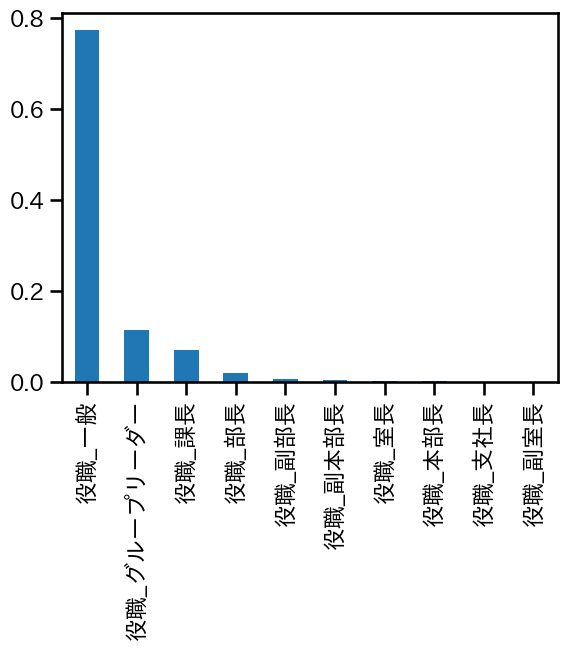

In [14]:
# ワンホットエンコーディング後の分布
ax = df_dummy.mean().plot(kind="bar")
ax.grid

In [15]:
# 

# この関数は、input_df という名前でPandasのデータフレーム (pd.DataFrame) を受け取ります
def create_category_one_hot_encoding_feture(input_df: pd.DataFrame):
    # 列の名前 ("category") を、column_name という変数に格納
    column_name = "category"
    # input_df データフレームから category 列（input_df[column_name]）を取り出し、
    # .unique() を使って重複しないカテゴリの種類をすべてリストアップ
    unique_values = input_df[column_name].unique()
    # category 列をカテゴリ型データに変換しています。
    # categories=unique_values と指定することで、カテゴリの順序を unique_values の順番に固定
    cat_series = pd.Categorical(input_df[column_name], categories=unique_values)
    # カテゴリ型のデータ (cat_series) を受け取り、ワンホットエンコーディングを実行
    df_dummy = pd.get_dummies(cat_series, prefix=column_name)
    # データフレームの列名（df_dummy.columns）を一度リスト形式に変換し、
    # それを再度列名として設定し直しています。必須ではありません。
    df_dummy.columns = df_dummy.columns.tolist()
    
    return df_dummy

create_category_one_hot_encoding_feture(df_train)

,category_コンテンツ・サービス・デザイン,category_コーポレート管理部門/技術・データ・BPR,category_プロダクトマネジメント,category_マーケティング,category_事業企画・開発・研究,category_営業
0,True,False,False,False,False,False
1,False,True,False,False,False,False
2,False,False,True,False,False,False
3,False,False,False,True,False,False
4,False,False,False,False,True,False
...,...,...,...,...,...,...
7333,False,True,False,False,False,False
7334,False,False,True,False,False,False
7335,False,False,False,True,False,False
7336,False,False,False,False,True,False


In [44]:
# career.csvの加工
import re

# データの読み込み
df_career = pd.read_csv(os.path.join(INPUT_DIR, "career.csv"), encoding='utf-8-sig')

# 回答の文字列から先頭の数字を抽出する関数
def extract_score(value):
    # 値が文字列でない場合（例: 空白）も考慮
    if not isinstance(value, str):
        return np.nan
    
    # 正規表現で文字列の先頭にある数字（\d）を検索
    match = re.search(r'^\d', value.strip())
    
    if match:
        # 数字が見つかった場合、整数に変換して返す
        return int(match.group(0))
    else:
        # 数字が見つからない場合はNaN（欠損値）を返す
        return np.nan

# 社員番号以外のすべての列に関数を適用
# df_career.columns[1:] は「1列目以降のすべての列」という意味
for col in df_career.columns[1:]:
    df_career[col] = df_career[col].apply(extract_score)

# スコアを反転させるカラムのリスト
reverse_cols = [
    "自分のこれからのキャリアには、あまり関心がない\n",
    "これからのキャリアをどう歩むべきか、あまり考えていない\n",
    "納得いくキャリアを歩めない原因の大半は周囲の環境にある\n",
    "キャリアは周りの環境によって決められていくものだと思う\n"
]

# カラム名に改行文字が含まれていると表示が崩れることがあるため、
# 表示用に改行を削除したカラム名のリストを作成
display_cols = [col.strip() for col in reverse_cols]
# 元のデータフレームのカラム名も一時的に修正
df_career.columns = [col.strip() if col in reverse_cols else col for col in df_career.columns]


print("--- 🔢 スコア反転前のデータ ---")
print(df_career[display_cols].head())

# 対象となる各カラムのスコアを反転させる
for col in reverse_cols:
    if col in df_career.columns:
        df_career[col] = 6 - df_career[col]
    else:
        print(f"警告: カラム '{col.strip()}' が見つかりませんでした。")

print("\n" + "="*50 + "\n")

print("--- 🔄 スコア反転後のデータ ---")
print(df_career[display_cols].head())

# 処理後のデータを確認
print("--- 全ての処理が完了した後のデータ ---")
print(df_career.head())



--- 🔢 スコア反転前のデータ ---
   自分のこれからのキャリアには、あまり関心がない  これからのキャリアをどう歩むべきか、あまり考えていない  \
0                        4                            3   
1                        1                            1   
2                        1                            1   
3                        5                            1   
4                        2                            2   

   納得いくキャリアを歩めない原因の大半は周囲の環境にある  キャリアは周りの環境によって決められていくものだと思う  
0                            3                            5  
1                            1                            1  
2                            1                            1  
3                            1                            1  
4                            1                            2  
警告: カラム '自分のこれからのキャリアには、あまり関心がない' が見つかりませんでした。
警告: カラム 'これからのキャリアをどう歩むべきか、あまり考えていない' が見つかりませんでした。
警告: カラム '納得いくキャリアを歩めない原因の大半は周囲の環境にある' が見つかりませんでした。
警告: カラム 'キャリアは周りの環境によって決められていくものだと思う' が見つかりませんでした。


--- 🔄 スコア反転後のデータ ---
   自分のこれからのキャリアには、あまり関心がない  こ

特徴量エンジニアリングを実施したデータフレームを結合する

In [19]:

def build_feature(input_df: pd.DataFrame, feature_functions: List) -> pd.DataFrame:
    # カラのデータフレームを用意
    out_df = pd.DataFrame()
    print("start build feature...")


    # 各特徴生成関数事で
    for func in feature_functions:

        with Timer(prefix=f"create {func.__name__}"):
            # 特徴量を作成
            _df = func(input_df)

        # 横方向axis=1で結合
        out_df = pd.concat([out_df, _df], axis=1)
    return out_df

In [20]:
# 作成した特徴量をfunctionsにまとめる
functions = [
    create_career_one_hot_encoding_feature,
    create_positon_aggregation_feture,
    create_category_one_hot_encoding_feture,
]

In [21]:
# functionsをがっちゃんこする
with Timer(prefix="build train..."):
    df_train_feat = build_feature(df_train, feature_functions=functions)

with Timer(prefix="build test..."):
    df_test_feat = build_feature(df_test, feature_functions=functions)


start build feature...
create create_career_one_hot_encoding_feature 0.041[s]
create create_positon_aggregation_feture 0.046[s]
create create_category_one_hot_encoding_feture 0.006[s]
build train... 0.098[s]
start build feature...
create create_career_one_hot_encoding_feature 0.039[s]
create create_positon_aggregation_feture 0.038[s]
create create_category_one_hot_encoding_feture 0.010[s]
build test... 0.090[s]


In [22]:
# trainとtestのカラムが完全に一致していることを確認する。列数がずれていたら分かるようになる。
assert df_train_feat.columns.equals(df_test_feat.columns)

In [23]:
# モデルの作成(LightGBM)
# 
def fit_lgbm(X,
             y,
             cv,
             params: dict=None,
             verbose: int=50):
    # パラメータがない時は、空のdictで置き換える
    if params is None:
        params = {}
    
    models = []
    n_records = len(X)
    # training data のtargetと同じだけのゼロ配列を用意
    oof_pred = np.zeros((n_records, ), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        # 交差検定。cv instanceで分割する
        # trainingデータをtrain/validに分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMClassifier(**params)

        with Timer(prefix="fit fold={}".format(i)):
            clf.fit(x_train, y_train,
                    eval_set=[(x_valid, y_valid)],
                    callbacks=[lgbm.callback.early_stopping(stopping_rounds=100),
                        lgbm.log_evaluation(period=verbose),],)

        # 予測確率を出力してもらう
        pred_i =clf.predict_proba(x_valid)
        # outputの形はsape = (n_samples, 2)になっていることに注意する
        y_pred_prob = pred_i[:, 1]

        oof_pred[idx_valid] = y_pred_prob
        models.append(clf)

        # 今回の指標のMAEで計算する
        score = roc_auc_score(y_valid, y_pred_prob, )
        print(f" -fold{i} - {score:.4f}")
    return oof_pred, models

# 5つのバリデーションに分けている
fold = GroupKFold(n_splits=5, )
cv = list(fold.split(df_train_feat.values, df_train["target"], groups=df_train["社員番号"]))

In [24]:
# パラメーター
params = {
    # 目的関数。これの意味で最少となるようなパラメーターを探す
    # 今回は0または1問題なので、よく使われるbinaryを利用
    "objective": "binary",

    # 学習率：小さいほど滑らかな決定領域が作られ、性能向上につながるが時間がかかる
    "learning_rate": .05,

    # 木の最大値：early_stoppingという枠組みで期の数は制御されるようにしているため、大きい値を指定しておく
    "n_estimators": 1000,

    # 特徴重要度計算のロジック
    "importance_type": "gain",
    "random_state": 510,

    # ログを少なめに
    "verbose": -1
}


In [25]:
with Timer(prefix="training..."):
    oof, models = fit_lgbm(X=df_train_feat.values, y=df_train["target"].values, cv=cv, params=params)

# 実行すると-fold0 - 0.6156などと出力される。
# 交差検定毎のスコアを出すことができる。

Training until validation scores don't improve for 100 rounds
[50]	valid_0's binary_logloss: 0.168244
[100]	valid_0's binary_logloss: 0.172955
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.165598
fit fold=0 0.641[s]
 -fold0 - 0.6156
Training until validation scores don't improve for 100 rounds
[50]	valid_0's binary_logloss: 0.170901
[100]	valid_0's binary_logloss: 0.173934
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.168666
fit fold=1 0.265[s]
 -fold1 - 0.6139
Training until validation scores don't improve for 100 rounds
[50]	valid_0's binary_logloss: 0.17828
[100]	valid_0's binary_logloss: 0.179958
[150]	valid_0's binary_logloss: 0.180949
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.178248
fit fold=2 0.316[s]
 -fold2 - 0.6437
Training until validation scores don't improve for 100 rounds
[50]	valid_0's binary_logloss: 0.153012
[100]	valid_0's binary_logloss: 0.154191
Early stopping, best iteration is:
[33]	valid_0's bi

In [26]:
# trainデータを用いてモデルの検証を実施する。
roc_auc_score(df_train["target"], oof)

0.6266777638095369

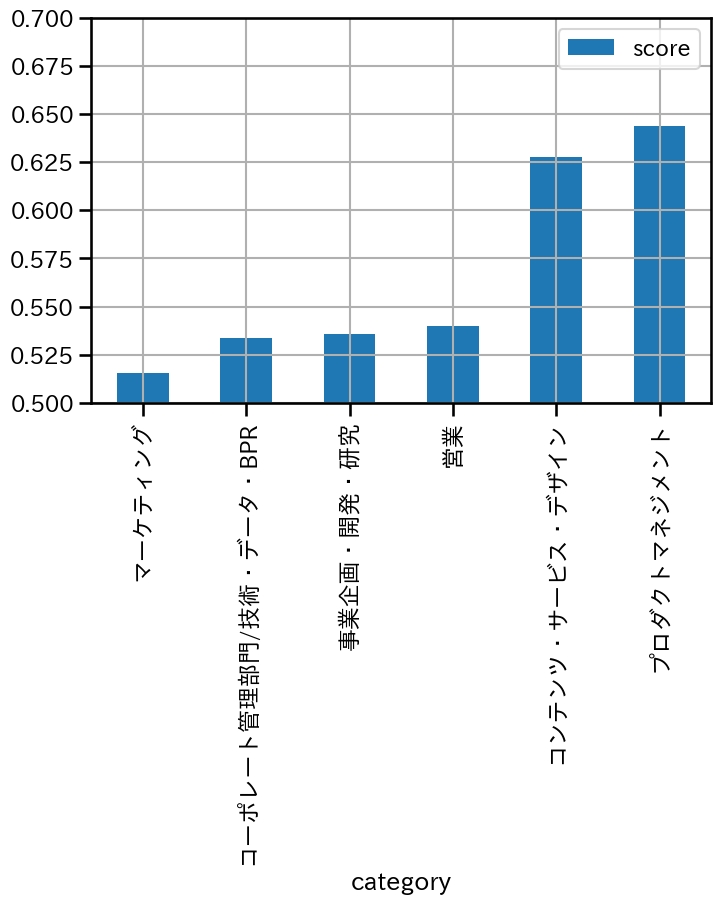

In [27]:
# 複数のカテゴリごとに応募有無を予測しなくてはならない
# どのカテゴリの予測が難しくて、どのカテゴリの予測が簡単なのかを把握しておくと良い
scores = []
for cat_name, _df in df_train.groupby("category"):
    idx = _df.index
    score_i = roc_auc_score(df_train["target"].iloc[idx], oof[idx])

    scores.append({
        "category": cat_name,
        "score": score_i
    })

fig, ax = plt.subplots(figsize=(8,5))
pd.DataFrame(scores).set_index("category").sort_values("score").plot(kind="bar", ax=ax)
ax.set_ylim([.5, .7])
ax.grid()

# 部署ごとにどのくらい予測があたっているかを確認することができる。
# マーケティングをどうやって予測できるかなどを考えてみる→新たな特徴量を考える

C:\Users\堀江雅彦\AppData\Local\Temp\ipykernel_27408\411243715.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=feature_importance_df,


Text(0.5, 1.0, 'Feature Importance (LightGBM)')

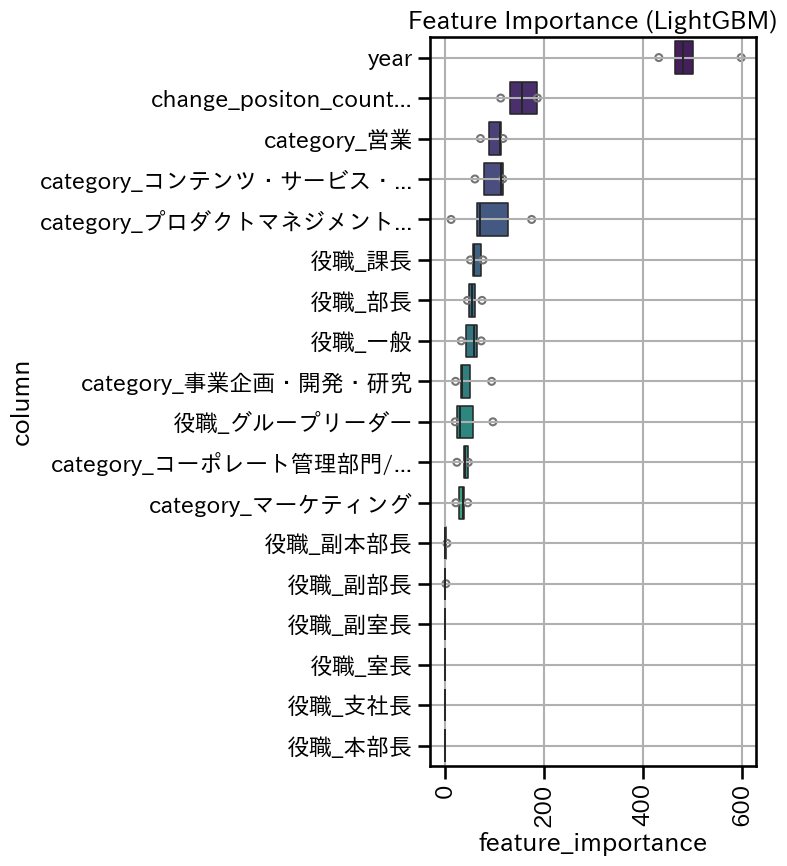

In [28]:
# 特徴重要度
# 大事な特徴量と大事ではない特徴量を探せる
# LightGBM用の特徴量重要度
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame(models)
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_

        columns = [c if len(c) < 20 else c[:20] + "..." for c in feat_train_df.columns]
        _df["column"] = columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df],
                                          axis=0, ignore_index=True)
    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index[:50]
    
    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .5)))
    sns.boxenplot(data=feature_importance_df,
                  x="feature_importance",
                  y="column",
                  order=order,
                  ax=ax,
                  palette="viridis",
                  orient="h"
                  )
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax

fig, ax = visualize_importance(models, df_train_feat)
ax.set_title("Feature Importance (LightGBM)")

In [ ]:
# 予測ファイルを作る。5こ予測ファイルを作ってその平均でモデルが構築される。
df_submission = pd.DataFrame()

predicts = [model.predict_proba(df_test_feat)[:, 1]for model in models]
predict_i = np.array(predicts).mean(axis=0)
df_submission["target"] = predict_i

# 1. 現在の日時を取得
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M")
filename = f"{timestamp}_submission.csv"

df_submission.to_csv(os.path.join(OUTPUT_DIR, filename),index=False)

In [ ]:
# # --- 2. 各データの集計・加工 ---

# # 応募者データ（ターゲット）の作成
# df_target = df_train.groupby('社員番号')['target'].max().reset_index()

# # 最新の役職データを抽出
# df_position_latest = df_position.sort_values('year').groupby('社員番号').last().reset_index()

# # 残業時間の平均を算出
# df_overtime_avg = df_overtime.groupby('社員番号')['hours'].mean().reset_index()
# df_overtime_avg = df_overtime_avg.rename(columns={'hours': '月平均残業時間'})

# # 研修(hr)の受講回数をカウント
# df_hr_count = df_hr.groupby('社員番号').size().reset_index(name='研修受講回数')

# # DX研修の受講回数をカウント
# df_dx_count = df_dx.groupby('社員番号').size().reset_index(name='DX研修受講回数')

# # Udemyのアクティビティ数をカウント
# df_udemy_count = df_udemy.groupby('社員番号').size().reset_index(name='Udemyアクティビティ数')

# # キャリアアンケートのデータを加工
# # カラム名を短縮 (例: career_q1, career_q2...)
# original_career_columns = df_career.columns.tolist()
# new_career_columns = {col: f'career_q{i}' for i, col in enumerate(original_career_columns)}
# df_career_processed = df_career.rename(columns=new_career_columns)
# df_career_processed = df_career_processed.rename(columns={'career_q0': '社員番号'}) # 社員番号のカラム名は元に戻す

# # 回答の文字列からスコア（数字）を抽出する関数
# def extract_score(value):
#     if isinstance(value, str):
#         match = re.search(r'^(\d)', value.strip())
#         if match:
#             return int(match.group(1))
#     return None # 数値が見つからない場合はNone（欠損値）

# # 社員番号以外の全カラムに適用
# for col in df_career_processed.columns:
#     if col != '社員番号':
#         df_career_processed[col] = df_career_processed[col].apply(extract_score)


